# Neural Style Transfer



In this part of the assignment, we will walk you through Neural Style Transfer, an algorithm presented by [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Gatys_Image_Style_Transfer_CVPR_2016_paper.html), Gatys et al. Neural Style Transfer allows one to turn an input image into a new artistic style. The algorithm takes as inputs the content-image and the style-image, and generates an output that looks similar to the content of the content-image and the artistic style of the style-image. As an example, here we present the magnifacent [Taipei-101](https://en.wikipedia.org/wiki/Taipei_101) with the art style from [The Scream](https://en.wikipedia.org/wiki/The_Scream).

<img src="https://user-images.githubusercontent.com/7057863/114615612-e7db1980-9c73-11eb-98d7-da9d1e8025c2.png" alt="drawing" width="600"/>

The principle is simple: we define two losses, one for the content and one for the style. Then, we can run backpropagation to update an empty image for minimizing both its content-loss with the content-image and its style-loss with the style-image. In the following, you will be asked to run the algorithm with different settings and answer multiple-choice questions.

**Reference**: [PyTorch's neural style transfer tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)


In [1]:
!wget https://user-images.githubusercontent.com/7057863/114615715-017c6100-9c74-11eb-86a1-cf84a1f0b172.jpg -O scream.jpg
!wget https://user-images.githubusercontent.com/7057863/114615725-03debb00-9c74-11eb-8a5e-a7cfd117058e.jpg -O taipei-101.jpg

--2022-04-19 05:08:15--  https://user-images.githubusercontent.com/7057863/114615715-017c6100-9c74-11eb-86a1-cf84a1f0b172.jpg
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95912 (94K) [image/jpeg]
Saving to: ‘scream.jpg’

scream.jpg          100%[===================>]  93.66K  --.-KB/s    in 0.02s   

2022-04-19 05:08:15 (5.43 MB/s) - ‘scream.jpg’ saved [95912/95912]

--2022-04-19 05:08:15--  https://user-images.githubusercontent.com/7057863/114615725-03debb00-9c74-11eb-8a5e-a7cfd117058e.jpg
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.109.133

## Import Packages

In [2]:
# importing libraries to implement style-transfer

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Images

In [3]:
# desired size of the output image
imsize = (512, 521) if torch.cuda.is_available() else (128, 128)  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("scream.jpg")
content_img = image_loader("taipei-101.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

## Visualize Inputs

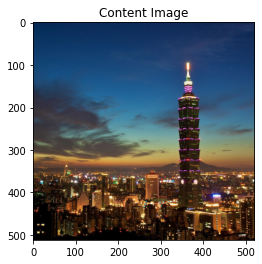

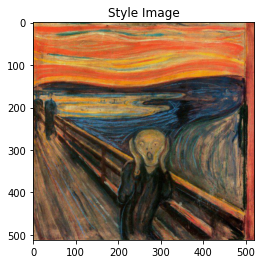

In [4]:
# visualizing the content and style images
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(style_img, title='Style Image')

## Losses

Read **section 2. Deep image representations** of [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

In [6]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    # inner product between the vectorised feature maps i and j in layer l
    G =  features@features.T

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

#### Multiple-choice Questions (select all that apply):
Different from the content-loss which computes the mean square error of the feature maps of the optimized image and the content image, we computed the `gram_matrix` for the style-loss because (b)(c).

- (a) style-loss should encode the spatial correspondence between the optimized image and the style-image.
- (b) style-loss shouldn't encode the spatial correspondence between the optimized image and the style-image.
- (c) style-loss should match the distribution of features found in the optimized image and the style-image.
- (d) style-loss shouldn't match the distribution of features found in the optimized image and the style-image.

In [7]:
# importing vgg-16 pre-trained model
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

## Specify which layers to use for losses

Run the code till the final cell twice, one with `content_layers_default = ['conv_5']` and the other one with `content_layers_default = ['conv_1']`. Attach the results in the report.

#### Multiple-choice Questions (select all that apply):
Using `conv_5` or `conv_1` as the content-loss layer produces different results because (b)(c).

- (a) `conv_5` features care more about the exact pixel values reconstruction of the content-image.
- (b) `conv_1` features care more about the exact pixel values reconstruction of the content-image.
- (c) `conv_5` features care more about the semantic content of the content-image.
- (d) `conv_1` features care more about the semantic content of the content-image.

In [12]:
# TODO: Run 1) content_layers_default = ['conv_5'] and 2) content_layers_default = ['conv_1']. 
#       Aattach the results in your report.
# content_layers_default = ['conv_5']
content_layers_default = ['conv_1']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']  # ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

## Optimization

In [13]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=100000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


run [50]:
Style Loss : 6.965201 Content Loss: 0.449397

run [100]:
Style Loss : 2.243775 Content Loss: 0.540566

run [150]:
Style Loss : 0.839860 Content Loss: 0.609797

run [200]:
Style Loss : 0.353432 Content Loss: 0.650011

run [250]:
Style Loss : 0.200264 Content Loss: 0.636400

run [300]:
Style Loss : 0.139642 Content Loss: 0.603217



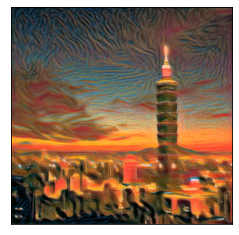

In [14]:
input_img = content_img.clone()
styled_output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
plt.xticks([])
plt.yticks([])
imshow(styled_output)

plt.show()

In [15]:
# save styled image
from torchvision.utils import save_image 
save_image(styled_output, "taipei-101-style.jpg")

## Harder, Better, Faster, Stronger

The style transfer algorithm presented here is cool, but we can do better! Notably, the iterative optimization process is slow, which limits its real-world application. Below, we attached several papers on speeding up the style transfer process. 


#### Briefly summarize one of the papers in your report.
- [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155), Johnson et al.
- [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization](https://openaccess.thecvf.com/content_ICCV_2017/papers/Huang_Arbitrary_Style_Transfer_ICCV_2017_paper.pdf), Huang and Belongie.

